# Evaluation

Run `scripts/<dataset>_training.py` and `scripts/<dataset>_testing.py` to evaluate the different refinements. 
The results will be stored as dictionaries in `metrics/<dataset>.pkl`.

In [153]:
import scanpy as sc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import numpy as np

sc.logging.print_header()
import squidpy as sq
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.9.8 anndata==0.9.2 umap==0.5.7 numpy==1.24.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.8 pynndescent==0.5.13
squidpy==1.2.3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load benchmarking results

In [71]:
files = [
    'metrics/visium_mouse_cortex.pkl',
    'metrics/visium_mouse_cortex_constrained_pp.pkl',
    'metrics/visium_mouse_cortex_cytospace_pp.pkl',
    'metrics/seqfish+_mouse_cortex.pkl',
    'metrics/merfish_mouse_hypothalamus.pkl',
    'metrics/seqfish_mouse_embryo.pkl'
]

In [135]:
metrics = dict()
for file in files:
    with open(file, 'rb') as f:
        metrics_subset = pickle.load(f)
    for metric in metrics_subset.keys():
        if metric not in metrics.keys():
            metrics[metric] = dict()
        for model in metrics_subset[metric].keys():
            if model not in metrics[metric].keys():
                metrics[metric][model] = dict()
            metrics[metric][model] = metrics_subset[metric][model]

In [136]:
for metric in metrics.keys():
    for model in metrics[metric].keys():
        if len(np.array(metrics[metric][model]).shape) > 1:
            metrics[metric][model] = np.mean(metrics[metric][model], axis=0)

## Heatmaps

In [141]:
df = copy.deepcopy(metrics)

for m in metrics.keys():
    for model in metrics[m]:
        df[m][model] = np.nanmean(df[m][model])

df = pd.DataFrame(df).abs()
df

,cell_map_consistency,ct_map_consistency,gene_expr_consistency,gene_expr_correctness,cell_map_agreement,ct_map_agreement,cell_map_certainty,ct_map_certainty,cell_map_consistency_seqfish,cell_map_consistency_seqfishP,...,cell_map_certainty_merfish,ct_map_certainty_seqfish,ct_map_certainty_seqfishP,ct_map_certainty_merfish,cell_map_correctness_seqfish,cell_map_correctness_seqfishP,cell_map_correctness_merfish,ct_map_correctness_seqfish,ct_map_correctness_seqfishP,ct_map_correctness_merfish
orig,0.593172,0.945265,0.852156,0.550204,0.866456,0.957769,0.721388,0.424707,0.420450,0.999899,...,0.626090,0.694708,0.468041,0.625918,0.661293,0.926255,0.816086,0.659179,0.483712,0.689770
random,0.000050,0.000758,0.001377,0.458956,0.605044,0.567397,0.605044,0.279929,0.000038,0.000363,...,0.640645,0.560146,0.324222,0.584156,0.000648,0.009545,0.001574,0.505995,0.388219,0.541724
hvg,0.830630,0.971981,0.926682,0.524544,0.935457,0.971736,0.798177,0.411367,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctg,0.471603,0.961494,0.753057,0.486168,0.832407,0.976840,0.774539,0.506452,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svg,0.363834,0.914470,0.712024,0.476934,0.799817,0.952344,0.762343,0.561572,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hvg+svg+ctg,0.743274,0.971767,0.886685,0.526033,0.909404,0.971278,0.778838,0.431627,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spapros,0.760408,0.971990,0.894439,0.504341,0.914080,0.970310,0.809977,0.438032,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_cosine_similarity,0.686703,0.960119,0.887105,0.549583,0.894922,0.965010,0.762382,0.451207,0.489734,0.999914,...,0.645969,0.700282,0.476656,0.628919,0.719172,0.931107,0.843217,0.661011,0.482442,0.693774
ct_island,0.611554,0.946137,0.857408,0.550238,0.870836,0.950113,0.724656,0.404103,0.430505,0.999231,...,0.625533,0.693425,0.461664,0.594987,0.673345,0.925364,0.816773,0.659097,0.490950,0.683777
getis_ord_g_star,0.659637,0.955456,0.874170,0.547849,0.887310,0.963776,0.763600,0.453568,0.474296,0.999896,...,0.642650,0.700011,0.472793,0.628200,0.707591,0.931068,0.833698,0.666463,0.483187,0.690030


In [9]:
metric_names = list(df.columns)
metric_labels = dict()
for metric in metric_names:
    if "_seqfishP" in metric:
        metric_labels[metric] = "SeqFISH+"
    elif "_seqfish" in metric:
        metric_labels[metric] = "SeqFISH"
    elif "_merfish" in metric:
        metric_labels[metric] = "MERFISH"
    else: 
        metric_labels[metric] = "Visium"

models = list(df.index)
model_labels = {
    "random" : "$\\it{Random\ assignment}$", 
    "orig" : "$\\it{Vanilla}$",
    'hvg' : "scHVGs", 
    'ctg' : "CTGs", 
    'svg' : "SVGs", 
    'hvg+svg+ctg' : "scHVGs + CTGs + SVGs",
    'spapros' : "Spapros genes",
    "neighborhood_cosine_similarity" : "Spatial weighted gene expression", 
    "ct_island" : "Cell type islands enforcement", 
    "getis_ord_g_star" : "Getis-Ord G* preservation", 
    "moran_I" : "Moran's I preservation", 
    "geary_C" : "Geary's C preservation", 
    'entropy_reg' : "Entropy regularization", 
    'l1_reg' : "L1 regularization", 
    'l2_reg' : "L2 regularization", 
    "combi" : "Combination",
    "constrained":"Cell filtering during training", 
    "constrained_pp":"Cell filtering preprocessing",
    "constrained_pp_combi" : "Combination + \ncell filtering preprocessing",
    "cytospace_pp" : "Cell sampling preprocessing",
    'cytospace_pp_combi' : "Combination + \nCell sampling preprocessing",
}

In [145]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

pvalues = {}
for i in range(len(metric_names)):
    m = metric_names[i]
    pvalues[m] = []
    for mo in models:
        if mo in metrics[m].keys():
            _,pvalue = scipy.stats.mannwhitneyu(metrics[m][mo], metrics[m]["orig"], alternative="greater")
            pvalues[m].append(convert_pvalue_to_asterisks(pvalue))
        else:
            pvalues[m].append("")
pvalues_df = pd.DataFrame(pvalues, index=models)

In [11]:
metric_names_truth_comp = [metric for metric in metric_names if "correctness" in metric]
metric_names_runs_comp = [metric for metric in metric_names if metric not in metric_names_truth_comp]

cmap_truth_comp = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
cmap_runs_comp = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:orange"])
cmap_clear = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "white"])

### Gene subset

In [155]:
runtimes = pd.DataFrame({
            "random" : [0] * 9,
            "orig" : [35.82010269165039, 35.8702826499939, 35.81853222846985, 35.78240752220154, 35.791804790496826, 35.79258918762207, 35.802809715270996, 35.77779579162598, 35.79166030883789],
            "hvg": [9.557812690734863, 9.464809894561768, 9.493047952651978, 9.602404356002808, 9.542037963867188, 9.654044151306152, 9.51349687576294, 9.759645700454712, 9.509783267974854],
            "ctg" : [8.714023113250732, 8.681432008743286, 8.69970417022705, 8.678237915039062, 8.693213939666748, 8.72935175895691, 8.69254207611084, 8.687475442886353, 8.705013036727905],
            "svg" : [7.427520751953125, 7.214260101318359, 7.254720211029053, 7.216355323791504, 7.214090824127197, 7.241504907608032, 7.240078926086426, 7.367404937744141, 7.21972918510437],
            "hvg+svg+ctg" : [12.443064451217651, 12.419925928115845, 12.418939113616943, 12.466089725494385, 12.542001008987427, 12.626966714859009, 12.524576663970947, 12.529202461242676, 12.550411701202393],
            "spapros" : [8.531982421875, 8.529884338378906, 8.53866171836853, 8.52337908744812, 8.532057285308838, 8.611390352249146, 8.551242113113403, 8.565473318099976, 8.637438297271729],
           })

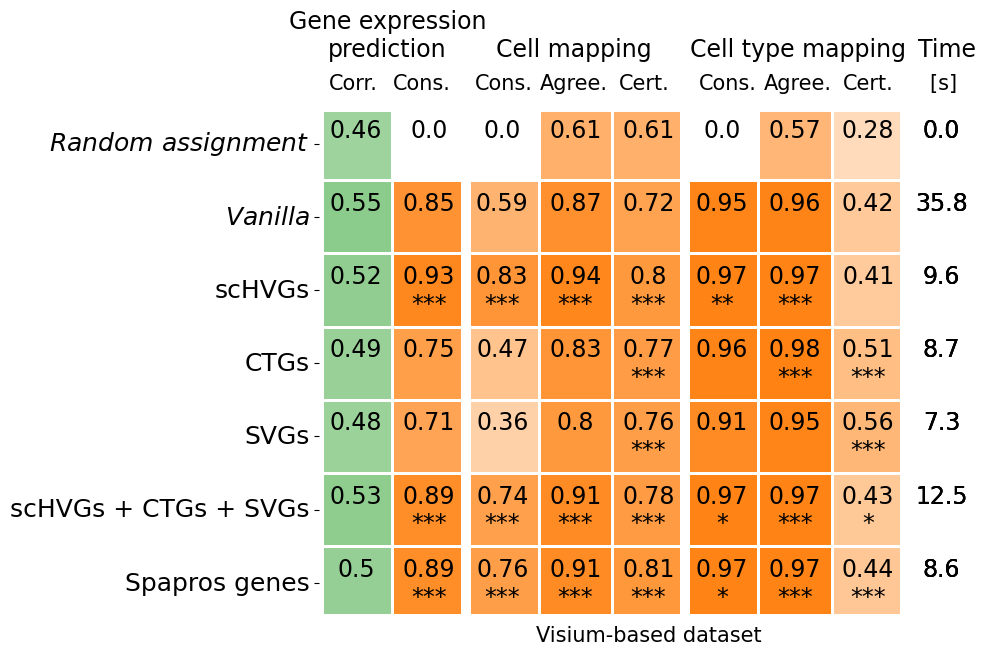

In [167]:
models_plot = ['random', 'orig', 
               'hvg', 'ctg', 'svg', 'hvg+svg+ctg', 'spapros']
metrics_plot = [
    'gene_expr_correctness',
    'gene_expr_consistency',
    'cell_map_consistency',
    'cell_map_agreement',
    'cell_map_certainty',
    'ct_map_consistency',
    'ct_map_agreement',
    'ct_map_certainty'
]
df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
df_plot["runtimes"] = runtimes.mean().round(decimals=1)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()
pvalues_plot["runtimes"] = ""

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*(len(metrics_plot)+1)+4, 1*len(models_plot)+0.8), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Gene expression\nprediction","Cell mapping","Cell type mapping","Time"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert.","Cons.", "Agree.", "Cert.","[s] "]
group_positions = [[0,1],[2,4],[5,7],[8,8]]
ncols = len(metrics_plot) + 1 #rt
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]),
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3]
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,
                group_labels2[i],
                ha='center',
                color="black", size=15,
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.43, group, ha="center", va="bottom", 
            color="black",
            size=17,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp,["runtime"]],
                                            [cmap_truth_comp,cmap_runs_comp,cmap_clear]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((5, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((8, 0), 1, 7, fill=False, edgecolor='white', lw=7))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.set_xlabel('Visium-based dataset', fontsize=15)

### Cell subset

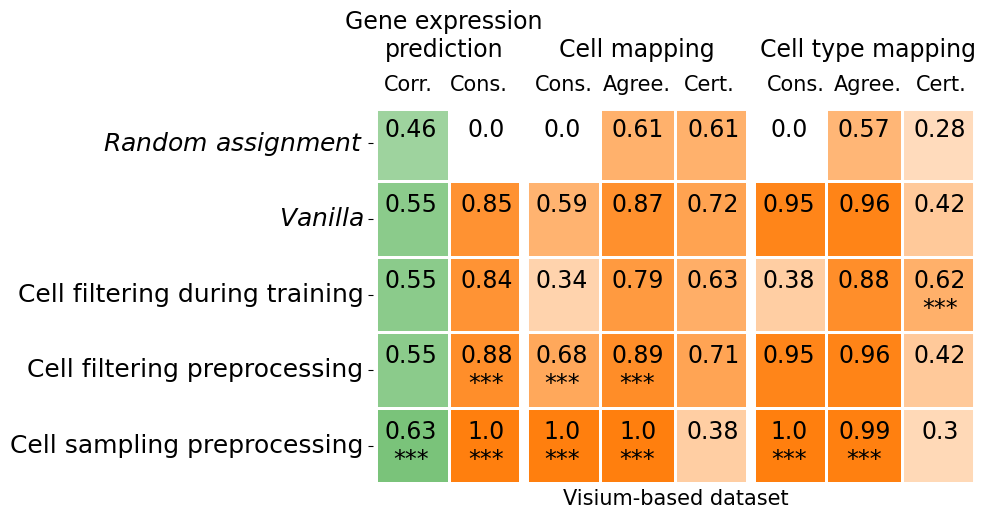

In [171]:
models_plot = ['random', 'orig', 
               'constrained', 'constrained_pp', 'cytospace_pp']
metrics_plot = [
    'gene_expr_correctness',
    'gene_expr_consistency',
    'cell_map_consistency',
    'cell_map_agreement',
    'cell_map_certainty',
    'ct_map_consistency',
    'ct_map_agreement',
    'ct_map_certainty'
]
df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+3.8, 1*len(models_plot)+1), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Gene expression\nprediction","Cell mapping","Cell type mapping"]
group_labels2 = ["Corr.","Cons.", "Cons.","Agree.", "Cert.","Cons.", "Agree.", "Cert."]
group_positions = [[0,1],[2,4],[5,7]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.3] 
        for i in range(group_positions[g_idx][0], group_positions[g_idx][1]+1):
            ax.text(
                i-group_positions[g_idx][0]  + 0.5, -0.01 + (y) * 1.5,#i-group_positions[g_idx][0]  + 1, (y) * 1.5, #+ (i-group_positions[g_idx][0])*0.1
                group_labels2[i],
                ha='center', 
                color="black", size=15
            ) 
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.43, group, ha="center", va="bottom", 
            color="black",
            size=17,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp,["runtime"]],
                                            [cmap_truth_comp,cmap_runs_comp,cmap_clear]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.add_patch(Rectangle((0, 0), 2, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((2, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.add_patch(Rectangle((5, 0), 3, 7, fill=False, edgecolor='white', lw=7))
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xticks([])
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.set_xlabel('Visium-based dataset', fontsize=15)

### Neighborhood information incorporation

Text(0.5, 1.13, 'Gene expression prediction')

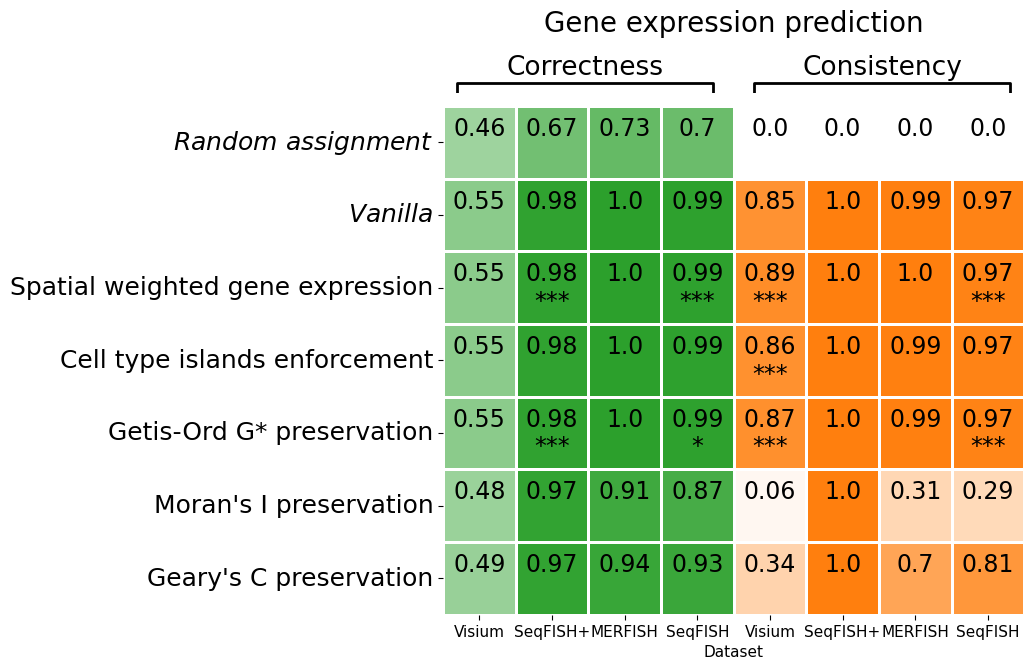

In [172]:
models_plot = ['random', 'orig', 
               'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"]

metrics_plot_basis = ['gene_expr_correctness', 'gene_expr_consistency',]
metrics_plot = [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+3.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]),
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.13)

Text(0.5, 1.13, 'Cell mapping')

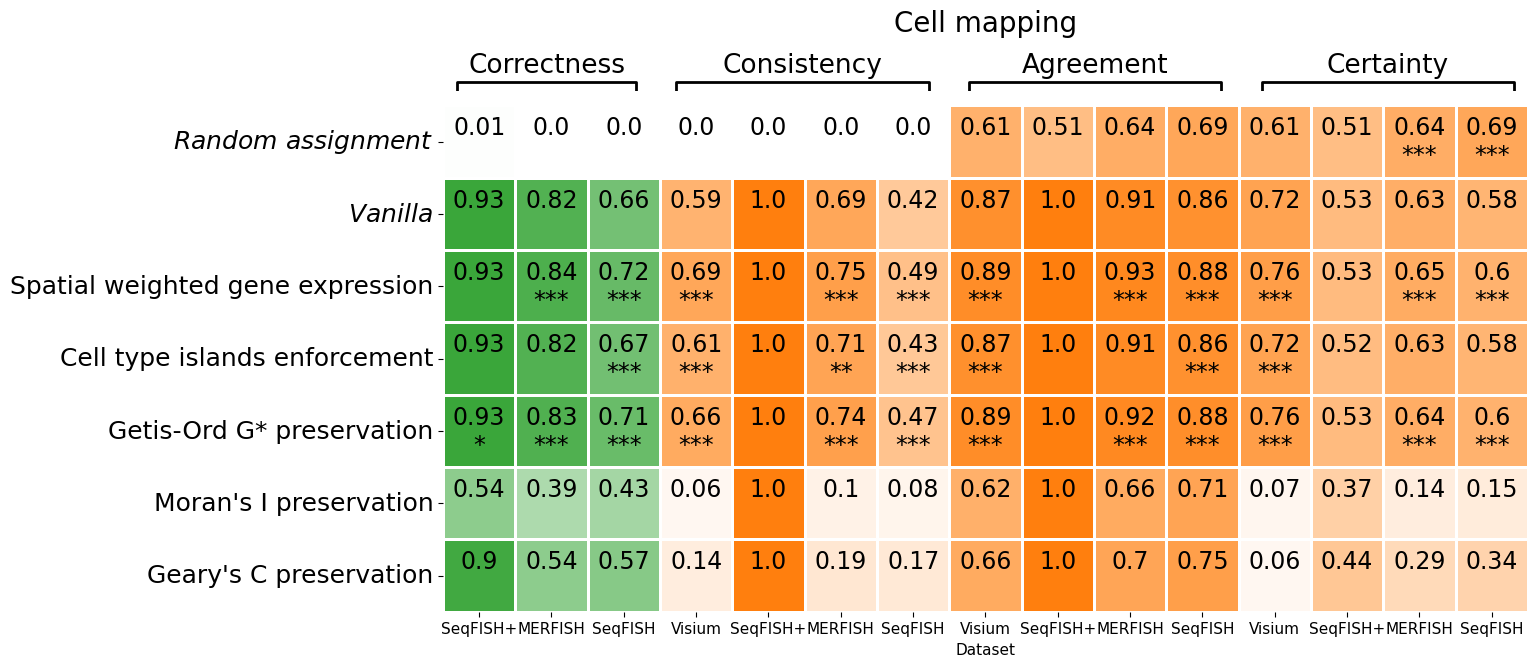

In [176]:
models_plot = ['random', 'orig', 
               'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"]

metrics_plot  = ["cell_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['cell_map_consistency', 'cell_map_agreement', 'cell_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.13)

Text(0.5, 1.13, 'Cell type mapping')

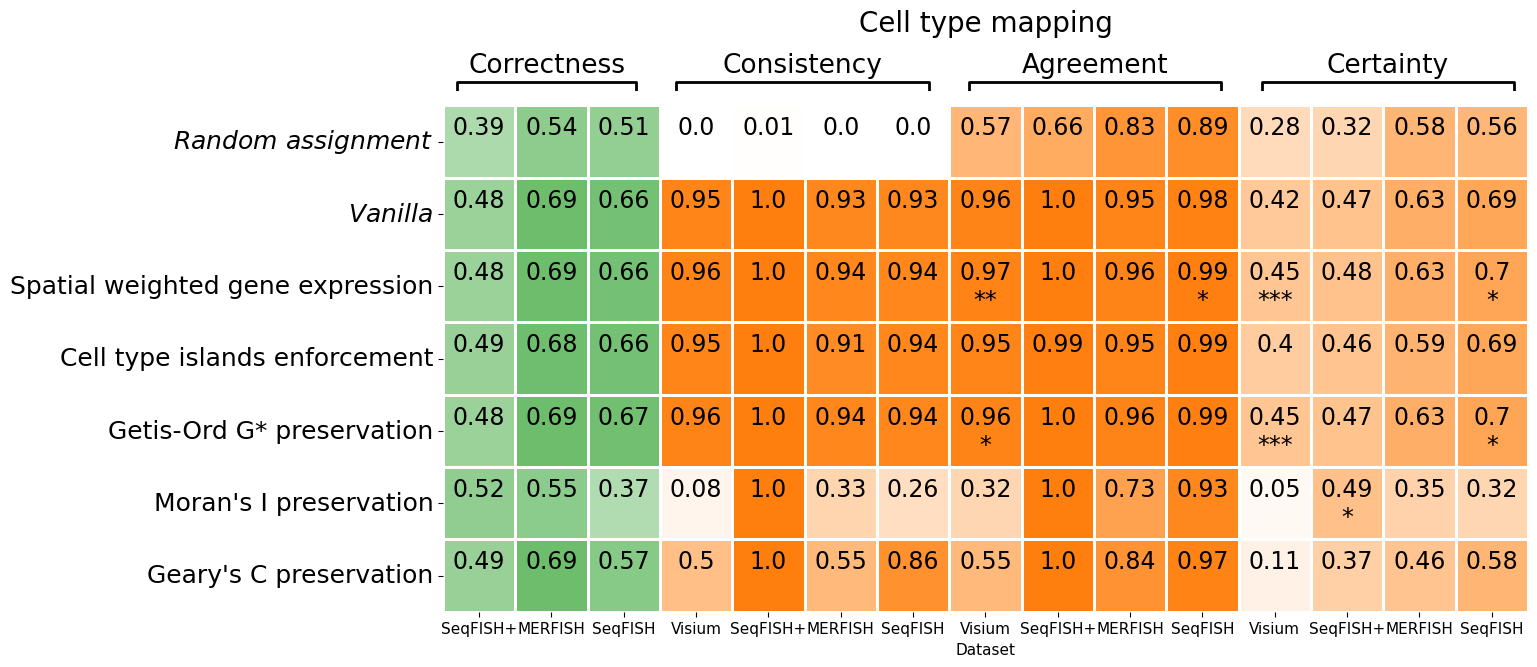

In [177]:
models_plot = ['random', 'orig', 
               'neighborhood_cosine_similarity', 'ct_island', 'getis_ord_g_star', 'moran_I', "geary_C"]

metrics_plot  = ["ct_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['ct_map_consistency', 'ct_map_agreement', 'ct_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.13)

### Regularization

Text(0.5, 1.17, 'Gene expression prediction')

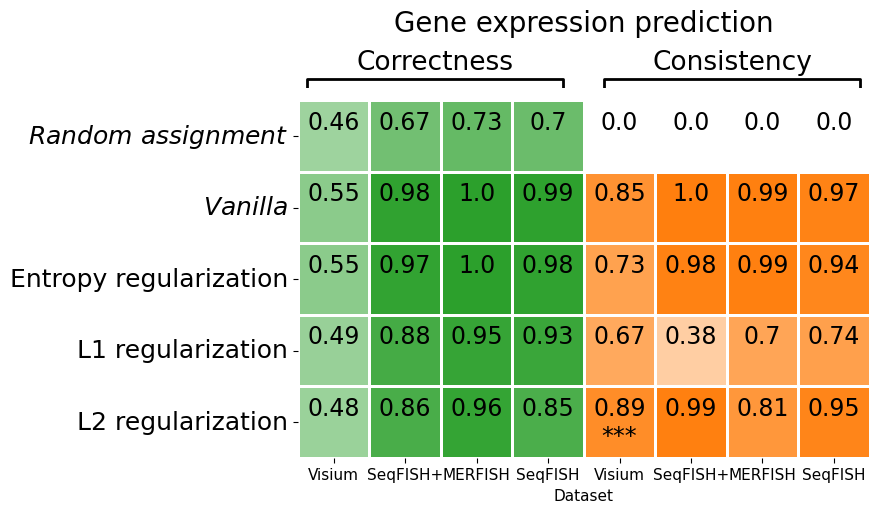

In [24]:
models_plot = ['random', 'orig', 
               'entropy_reg', 'l1_reg', 'l2_reg']

metrics_plot_basis = ['gene_expr_correctness', 'gene_expr_consistency',]
metrics_plot = [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+3.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]),
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell mapping')

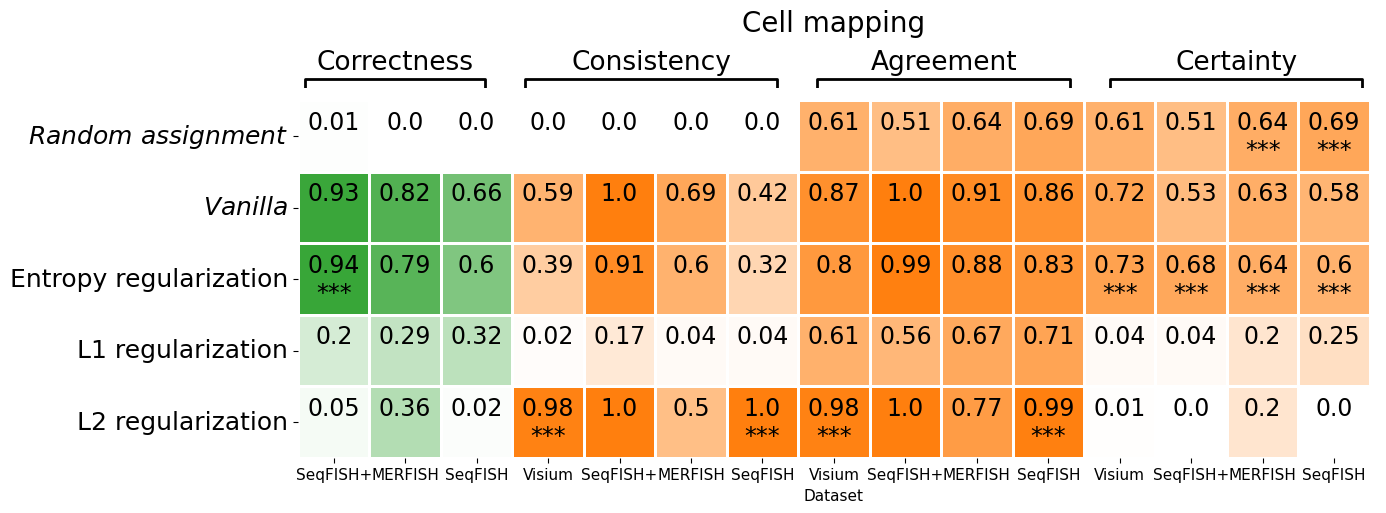

In [25]:
models_plot = ['random', 'orig', 
               'entropy_reg', 'l1_reg', 'l2_reg']

metrics_plot  = ["cell_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['cell_map_consistency', 'cell_map_agreement', 'cell_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell type mapping')

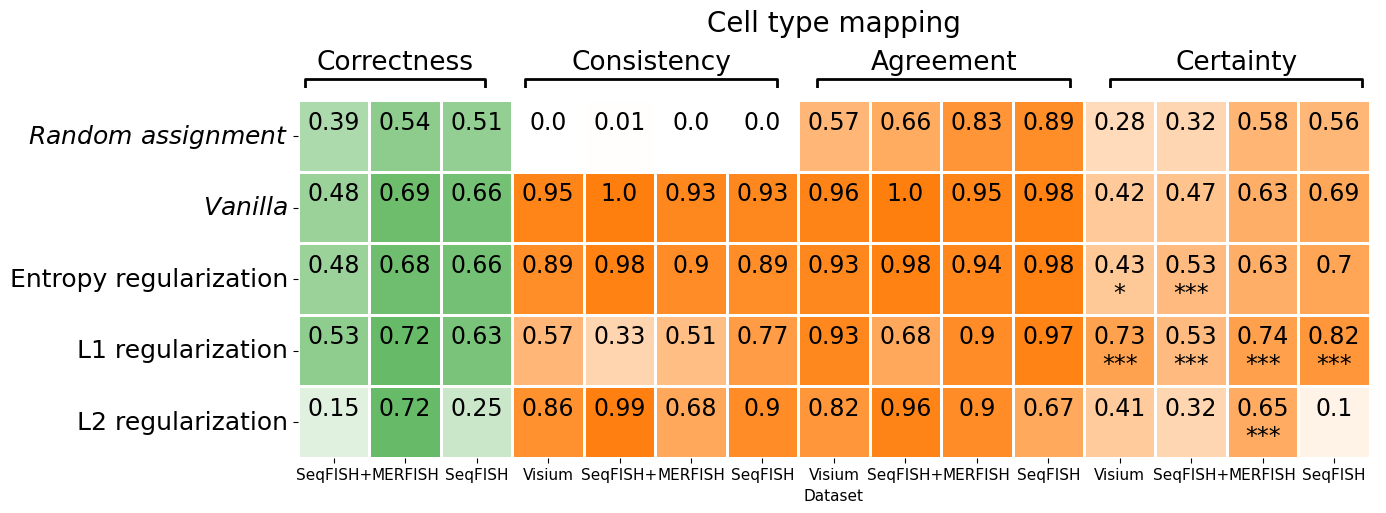

In [26]:
models_plot = ['random', 'orig', 
               'entropy_reg', 'l1_reg', 'l2_reg']

metrics_plot  = ["ct_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['ct_map_consistency', 'ct_map_agreement', 'ct_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

### Combi

Text(0.5, 1.17, 'Gene expression prediction')

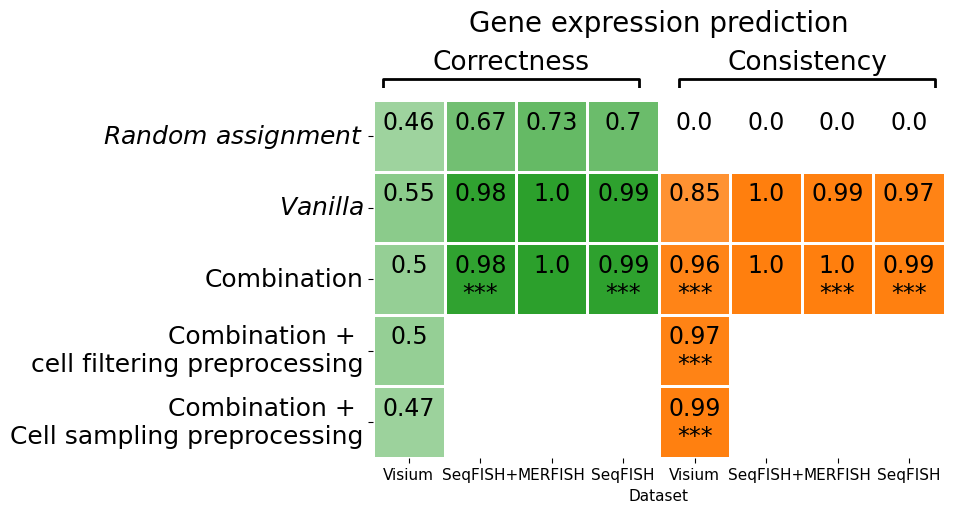

In [146]:
models_plot = ['random', 'orig', 
               "combi", "constrained_pp_combi", 'cytospace_pp_combi']

metrics_plot_basis = ['gene_expr_correctness', 'gene_expr_consistency',]
metrics_plot = [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+3.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency"]
group_positions = [[0,3],[4,7]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]),
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Gene expression prediction",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell mapping')

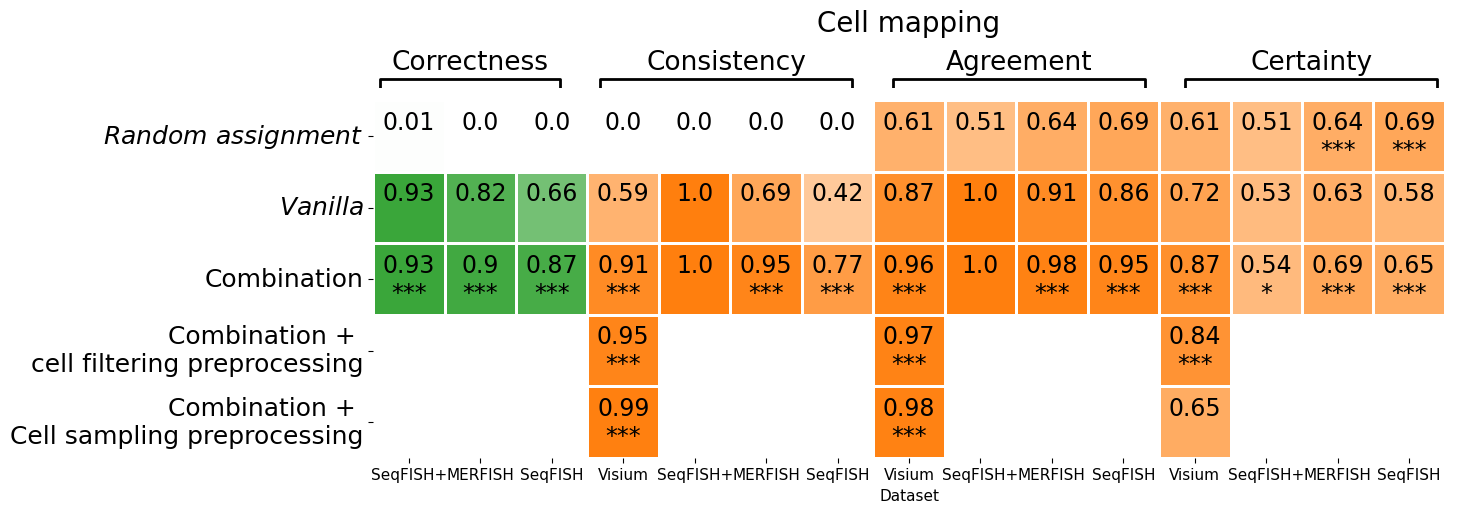

In [152]:
models_plot = ['random', 'orig', 
               "combi", "constrained_pp_combi", 'cytospace_pp_combi']

metrics_plot  = ["cell_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['cell_map_consistency', 'cell_map_agreement', 'cell_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)

Text(0.5, 1.17, 'Cell type mapping')

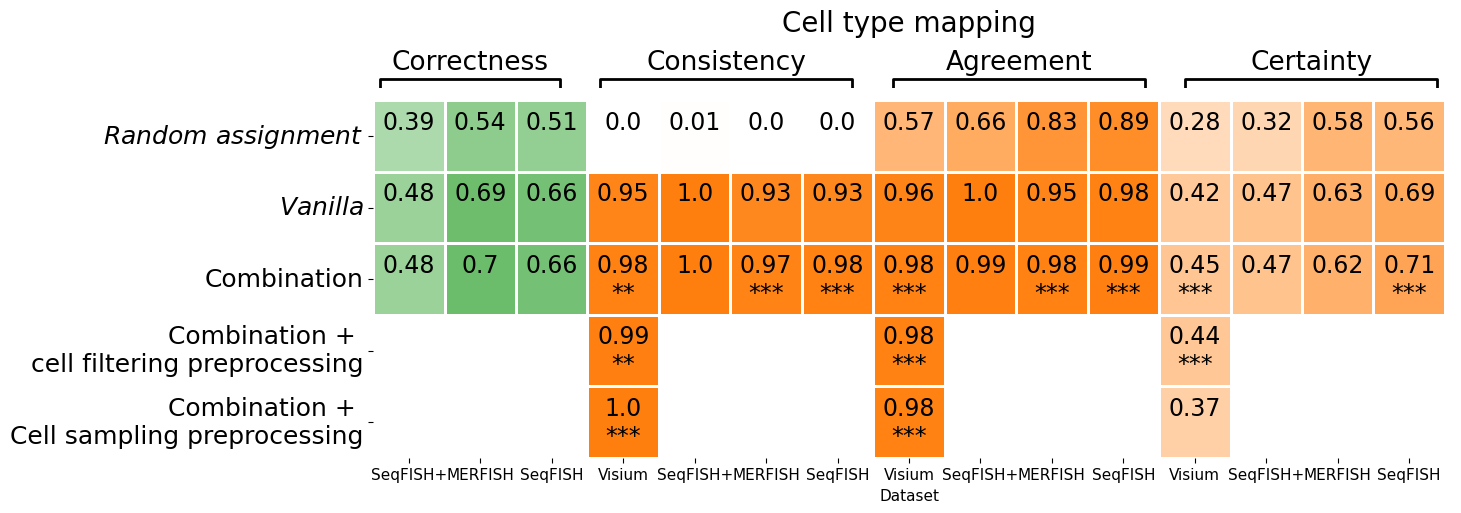

In [148]:
models_plot = ['random', 'orig', 
               "combi", "constrained_pp_combi", 'cytospace_pp_combi']

metrics_plot  = ["ct_map_correctness" + a for a in ["_seqfishP","_merfish", "_seqfish"]]
metrics_plot_basis = ['ct_map_consistency', 'ct_map_agreement', 'ct_map_certainty']
metrics_plot += [m+a for m in metrics_plot_basis for a in ["","_seqfishP","_merfish", "_seqfish"]]

df_plot = df.loc[models_plot,metrics_plot].copy().round(decimals=2)
pvalues_plot = pvalues_df.loc[models_plot,metrics_plot].copy()

plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(0.5*len(metrics_plot)+6.5, 1*len(models_plot)+0.6), 
                       sharey=True,)
ax.set_aspect("equal")
group_labels = ["Correctness","Consistency","Agreement","Certainty"]
group_positions = [[0,2],[3,6],[7,10],[11,14]]
ncols = len(metrics_plot)
nrows = len(models_plot) + 1  # 1 for group brackets
for g_idx, group in enumerate(group_labels):
        n_cols_group = group_positions[g_idx][1] - group_positions[g_idx][0] + 1
        ax = plt.subplot2grid((nrows, ncols), (0, group_positions[g_idx][0]), #autoscale_on = False,
                              colspan=n_cols_group, rowspan=1)

        ax.axis("off")
        ax.set_xlim([0, n_cols_group])
        ax.set_ylim([0, 1])
        x1, x2 = [0.2, n_cols_group - 0.2]
        y, h = [0, 0.15]
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=2.0, c="black")
        plt.text(
            (x1 + x2) * 0.5, (y) * 1.5 + 0.2, group, ha="center", va="bottom", 
            color="black",
            size=19,
        ) 

ax = plt.subplot2grid((nrows, ncols), (1, 0), colspan=ncols, rowspan=nrows - 1)

for metric_names_subset, custom_cmap in zip([metric_names_truth_comp,metric_names_runs_comp],
                                            [cmap_truth_comp,cmap_runs_comp]):
    data = df_plot.copy()
    data.loc[:,list(set(metrics_plot)-set(metric_names_subset))] = float('nan')
    al = sns.heatmap(data, cmap=custom_cmap, linewidths=1, 
                annot=df_plot.round(decimals=2).astype("str") + "\n" + pvalues_plot, 
                fmt = '', ax=ax, cbar = False, annot_kws={"size": 17, "color" : "black"},
                vmin=0,vmax=1,
                yticklabels = [model_labels[mo] for mo in models_plot],
                xticklabels = [metric_labels[mo] for mo in metrics_plot],
                mask=data.isnull(),
                square=True)
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='x', which='major', labelsize=11,labelrotation=0)
    ax.set_xlabel('Dataset', fontsize=11)
plt.title("Cell type mapping",fontdict={"fontsize":20}, x=0.5,y=1.17)